## **Titanic - Machine Learning from Disaster (Top 10%)**

In this project, it is necessary to find a model
that predicts which passengers survived the sinking of the Titanic.


### **Introduction**

Importing all of the necessary libraries and inspecting the data.

In [743]:
import joblib
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


# Load the passenger data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()
# print(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [744]:
df_train.info()
# df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Besides 'Age', only 'Cabin' and 'Embarked' have missing values (train data). We can inspect 'Embarked' column further and delete 'Cabin' since most of the values are missing. Also, we can see that 'Ticket' column do not have any meaningful data (all unique values). Thus, we can remove this column as well. 'Age' and 'Name' columns contain some important value so we will keep them.

In [745]:
# check value counts
print(df_train.Embarked.value_counts(dropna = False))
print(df_train.Name.value_counts(dropna = False))
print(df_train.Ticket.value_counts(dropna = False))

# drop unnecessary columns
df_train.drop(columns = ['Cabin','Ticket'],inplace = True)
df_test.drop(columns = ['Cabin','Ticket'],inplace = True)


df_train.head()

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### **Exploratory Data Analisys**

As a first step, we can check out the correlation between different features. A pair plot is also a good place to start.

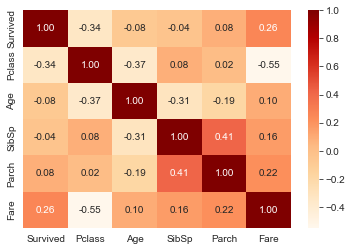

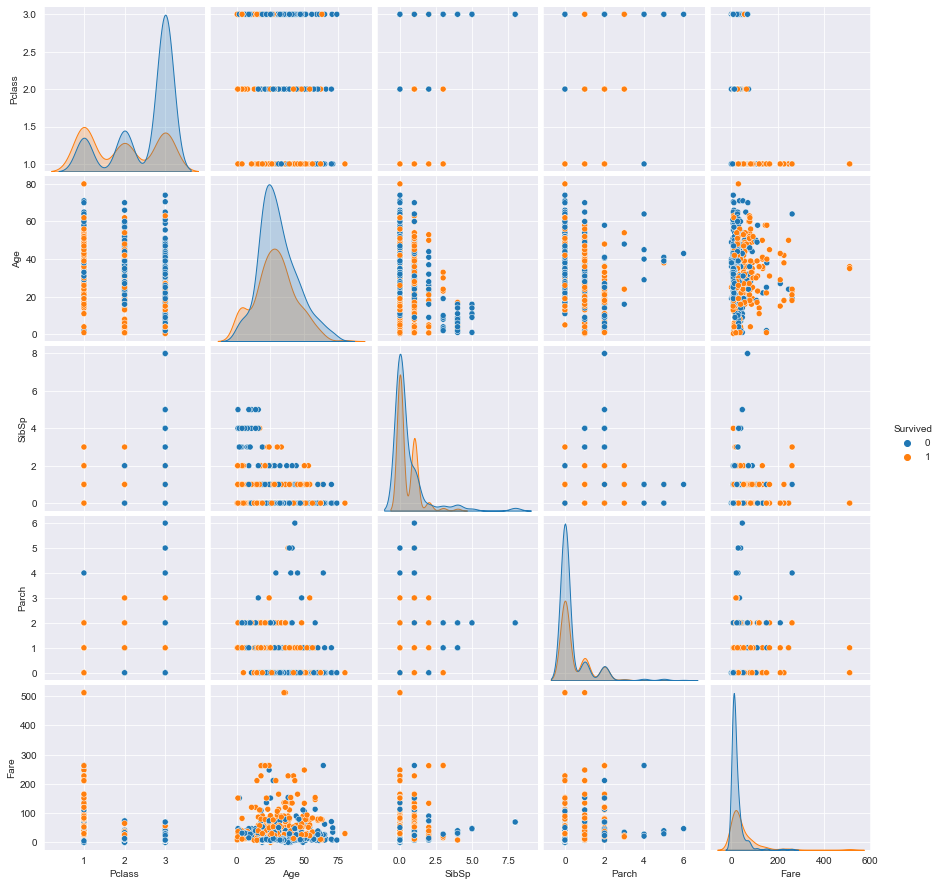

In [746]:
sns.set_style('darkgrid')

# correlation matrix
sns.heatmap(df_train.drop(columns = ['PassengerId'],axis = 1).corr(),cmap='OrRd',annot=True,fmt=".2f")
plt.show()

# pair plot
sns.pairplot(df_train.drop(columns = ['PassengerId'],axis = 1),hue = 'Survived')
plt.show()

We can see (from the correlation matrix) that only class and fare are related to survival and to each other. We would expect the age to be correlated to survival as well. On the pair plot we can see that young people have a higher survival rate. Also, it can be seen that the majority of the 3rd class died and the majority of the people traveling in the 1st class survived.

We can further inspect the categorical features of the data and their survival status.

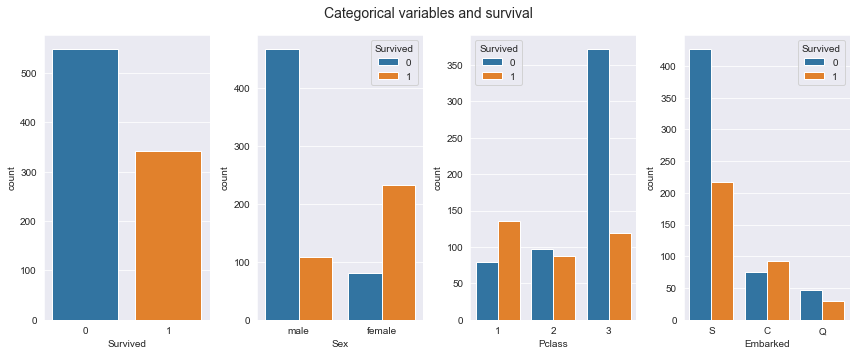

In [747]:
# plot categorical features
fig,axes=plt.subplots(1,4,figsize=(12,5))
sns.countplot(x="Survived",data=df_train,ax=axes[0])
sns.countplot(x="Sex",hue="Survived",data=df_train,ax=axes[1])
sns.countplot(x="Pclass",hue="Survived",data=df_train,ax=axes[2])
sns.countplot(x="Embarked",hue="Survived",data=df_train,ax=axes[3])
plt.suptitle("Categorical variables and survival",fontsize=14)
plt.tight_layout()

It is clear that women survived more then men. Also, people who were in class 1 and embarked at 'C' had a greater chance of survival. Thus, all three of these features ate important when predictiong the survival.

We can further check the 'Age' feature by plotting the histogram of the ages.

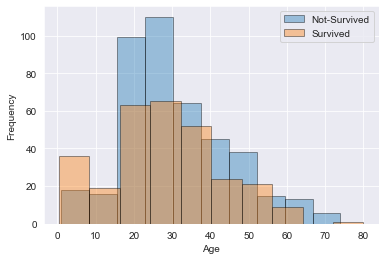

In [748]:
# create a histogram for Age feature
df_train.groupby("Survived").Age.plot(kind="hist", alpha = 0.4, ec="black", legend= True)
plt.xlabel("Age")
plt.legend(labels=["Not-Survived","Survived"])
plt.show()

We can see that age is indeed an important factor. Young people tend to survive more than old ones. Furthermore, we can compare the mean age value for men and women in different classes. This could be an important factor when filling the missing values for age feature.


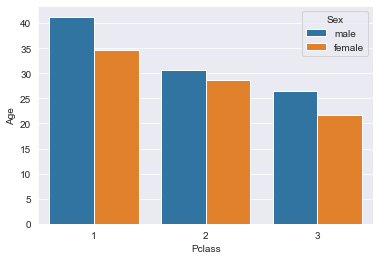

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64


In [749]:
# plot mean age values for different sex and Pclass 
sns.barplot(x="Pclass",hue="Sex",y="Age",data=df_train,ci=None)
plt.show()

print(df_train.groupby(["Pclass","Sex"]).Age.mean())

Next, we can explore the fare feature. Let's check the survival compared to the different fare value.

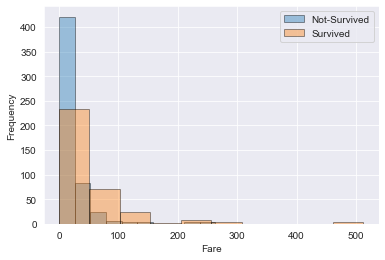

In [750]:
# plot a histogram of the fare feature
df_train.groupby("Survived").Fare.plot(kind="hist", alpha = 0.4, ec="black", legend= True)
plt.xlabel("Fare")
plt.legend(labels=["Not-Survived","Survived"])
plt.show()

It is clear that the fare value is connected to survival as well. Like in the 'Pclass' feature, people who paid more (better class) tend to survive. The fare value is directly connected to 'Pclass' feature which can also be seen in the correlation matrix.

### **Data Preprocessing**

 #### Name feature

First, we can start with 'Name' column. If we look at the 'Name' feature, we can see that each name comes with a title. We can extract these titles as a string followed by a dot.



In [751]:
# extract titles from Name feature
df_train["Title"] = df_train["Name"].str.extract('([A-Za-z]+)\.')
df_test["Title"] = df_test["Name"].str.extract('([A-Za-z]+)\.')

df_train["Title"].value_counts()
# df_test["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

We can further reduce the number of titles by grouping the common ones together and uncommon ones apart.

In [752]:
# group titles
def group_titles(title):
    if title in ['Ms', 'Mlle', "Miss"]: # young woman
        return 'Miss'
    elif title in ['Mme', 'Mrs','Lady']: # older woman
        return 'Mrs'
    elif title == 'Mr':
        return 'Mr'
    elif title == 'Master':
        return 'Master'
    else:
        return "Other" # uncommon ones
        
df_train["Title"] = df_train["Title"].map(group_titles)
df_test["Title"] = df_test["Title"].map(group_titles)

df_train["Title"].value_counts()

Mr        517
Miss      185
Mrs       127
Master     40
Other      22
Name: Title, dtype: int64

#### Sex and Embarked feature

'Sex' column is simply mapped to integers 0 and 1 and converted from categorical to numerical value. 'Embarked' column has 2 missing values which are filled with the mode value.

In [753]:
# Update sex column to numerical
df_train.Sex.replace(['female','male'],[1,0],inplace = True)
df_test.Sex.replace(['female','male'],[1,0],inplace = True)

# Fill the nan values in the Embarked column by the mode value of total data
df_train.Embarked.fillna(pd.concat([df_train,df_test], axis = 0).Embarked.mode()[0],inplace = True) # fill embarked considering ticket/fare or other features!!

#### 3. Age feature

Next, missing values in the 'Age' column can be filled with the mean value, considering 'Sex' and 'Pclass' as shown in the EDA part. This may not be the best case as the children or old people may get the mean age values. Another approach is to look at the titles and fill the missing values with corresponding mean values. Both test and train data were considered when computing mean values in order for better estimates.

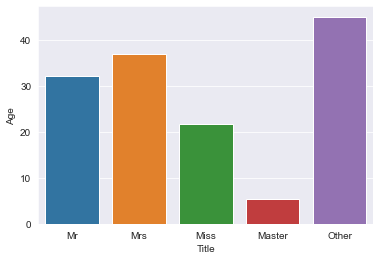

Title
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.982558
Other     45.074074
Name: Age, dtype: float64


In [754]:
# plot and check mean age for different titles
sns.barplot(x='Title',y="Age",data=pd.concat([df_train,df_test], axis = 0),ci=None)
plt.show()

print(pd.concat([df_train,df_test], axis = 0).groupby(['Title']).Age.mean())

In [755]:
# Fill the nan values in the age column considering 'Sex' and 'Pclass'
# df_train.Age.fillna(df_train.groupby(['Pclass','Sex']).Age.transform('mean'), inplace = True)

# Fill the nan values in the age column considering 'Title' column means
df_train.Age.fillna(pd.concat([df_train,df_test], axis = 0).groupby(['Title']).Age.transform('mean')[:891], inplace = True)
df_train.Age = df_train.Age.round(0).astype(int)

df_test.Age.fillna(pd.concat([df_train,df_test], axis = 0).groupby(['Title']).Age.transform('mean')[891:], inplace = True)
df_test.Age = df_test.Age.round(0).astype(int)

#### ParCh and SibSp features

'ParCh' and 'SibSp' columns can be joined together into a 'Family' feature. This has the number of people with whom the person was on the boat with. Another feature, 'Alone', can be added just in case (even though this is already included in 'Familiy' == 0).

In [756]:
# Family members analysis
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

# Create 'Alone' fetaure
df_train['Alone'] = df_train['Family'] == 0
df_train['Alone'] = df_train['Alone'].astype(int)

df_test['Alone'] = df_test['Family'] == 0
df_test['Alone'] = df_test['Alone'].astype(int)

We can quickly check the survival compared to the family size. It is clear that small families survived the most.

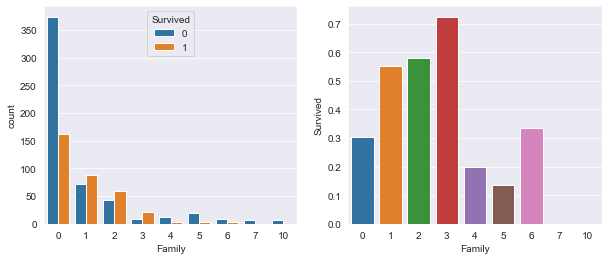

        Count  SurvivalPerc
Family                     
3          29     72.413793
2         102     57.843137
1         161     55.279503
6          12     33.333333
0         537     30.353818
4          15     20.000000
5          22     13.636364
7           6      0.000000
10          7      0.000000


In [757]:
# plot family size and survival
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.countplot(data = df_train, x = 'Family', hue = 'Survived', ax=axes[0])
sns.barplot(data = df_train, x = 'Family', y = 'Survived',ci = None, ax=axes[1] )
plt.show()

# check survival percentage for different family size
family_count = df_train.groupby("Family").size()
family_mean = (df_train.groupby("Family").Survived.mean())*100
print(pd.concat([family_count,family_mean],keys=["Count","SurvivalPerc"],axis=1).sort_values(by = 'SurvivalPerc', ascending = False))

#### Fare feature

We can check the correlation of the 'Fare' feature with other features. The highest negative correlation is with the 'Pclass'. Therefore, we will fill the missing value in the test data with the mean value corresponding to the 'Pclass' of that entry.

In [758]:
# check correlation between Fare and other features
print(df_train.corr()["Fare"].sort_values(ascending=False))

# fill missing values for Fare
df_test.Fare.fillna(df_train.groupby('Pclass').Fare.transform('mean'),inplace = True)

Fare           1.000000
Survived       0.257307
Family         0.217138
Parch          0.216225
Sex            0.182333
SibSp          0.159651
Age            0.092697
PassengerId    0.012658
Alone         -0.271832
Pclass        -0.549500
Name: Fare, dtype: float64


Furthermore, we can group the fare features by quartiles and check the survival rate. Then we can apply this grouping on both of our datasets.

In [759]:
# split fare into quartiles
df_train['FareGroup'] = pd.qcut(df_train['Fare'], 4)
print(df_train[['FareGroup', 'Survived']].groupby(['FareGroup']).mean().sort_values(by='FareGroup', ascending=True))

# group fare data into 4 groups
def group_fare(entry):
    if entry <= 7.91:
        return 0
    elif (entry > 7.91) & (entry <= 14.454):
        return 1
    elif (entry > 14.454) & (entry <= 31):
        return 2
    else:
        return 3

        
df_train['Fare'] = df_train.Fare.apply(group_fare)
df_test['Fare'] = df_test.Fare.apply(group_fare)

                 Survived
FareGroup                
(-0.001, 7.91]   0.197309
(7.91, 14.454]   0.303571
(14.454, 31.0]   0.454955
(31.0, 512.329]  0.581081


#### Categorical features one-hot encoding

Next, we have to encode the categorical features.

In [760]:
# Create different class columns
df_train[['FirstClass','SecondClass','ThirdClass']] = pd.get_dummies(df_train.Pclass)
df_test[['FirstClass','SecondClass','ThirdClass']] = pd.get_dummies(df_test.Pclass)

# Create different embarked columns
df_train[['Embarked_C','Embarked_Q','Embarked_S']] = pd.get_dummies(df_train.Embarked)
df_test[['Embarked_C','Embarked_Q','Embarked_S']] = pd.get_dummies(df_test.Embarked)

# Create different title columns
df_train = pd.concat([df_train,pd.get_dummies(df_train.Title)],axis = 1)
df_test = pd.concat([df_test,pd.get_dummies(df_test.Title)],axis = 1)

# drop old columns
df_train.drop(columns = ['Embarked','Pclass','SibSp','Parch','Title','Name','FareGroup'],inplace = True)
df_test.drop(columns = ['Embarked','Pclass','SibSp','Parch','Title','Name'],inplace = True)

df_train.head()

,PassengerId,Survived,Sex,Age,Fare,Family,Alone,FirstClass,SecondClass,ThirdClass,Embarked_C,Embarked_Q,Embarked_S,Master,Miss,Mr,Mrs,Other
0,1,0,0,22,0,1,0,0,0,1,0,0,1,0,0,1,0,0
1,2,1,1,38,3,1,0,1,0,0,1,0,0,0,0,0,1,0
2,3,1,1,26,1,0,1,0,0,1,0,0,1,0,1,0,0,0
3,4,1,1,35,3,1,0,1,0,0,0,0,1,0,0,0,1,0
4,5,0,0,35,1,0,1,0,0,1,0,0,1,0,0,1,0,0


#### Select features, split and standardize data

Here, we can choose different features that we want to include in our analysis and iteratively decide wich features contribute most effectively to the model. Then, the data is split eaither by a stratified split or by a random one. The data can also be standardized here (but it is already standardized later using the pipeline wit the models)

In [761]:
# Select the desired features
chosen_features = [ 'Sex',
                    'Age',
                    'FirstClass',
                    'SecondClass',
                    'ThirdClass',
                    'Family',
                    'Embarked_C',
                    'Embarked_Q',
                    'Embarked_S',
                    # 'Alone',
                    'Fare',
                    'Master',
                    'Miss',
                    'Mr',
                    'Mrs',
                    'Other'
                    ]


# split data into features and target variables                    
features = df_train[chosen_features]
survival = df_train.Survived

# Perform train and test split
stratify = None
X_train, X_test ,y_train, y_test = train_test_split(features,survival, test_size = 0.2, stratify=stratify)

# check data imbalance
print('Target variable (''Survived'') percentage in train data:')
print(y_train.value_counts(normalize = True))
print('Target variable (''Survived'') percentage in test data:')
print(y_test.value_counts(normalize = True))

# # Scale the feature data so it has mean = 0 and standard deviation = 1
# stdScaler = StandardScaler()
# X_train_std = stdScaler.fit_transform(X_train)
# X_test_std = stdScaler.transform(X_test)

Target variable (Survived) percentage in train data:
0    0.603933
1    0.396067
Name: Survived, dtype: float64
Target variable (Survived) percentage in test data:
0    0.664804
1    0.335196
Name: Survived, dtype: float64


### **Machine Learning Models**

We can test various models, perform hyperparameter tunning and compare the results for the same set of data.

#### Logistic Regression

In [762]:
# make pipeline to scale the data
LRpipe= Pipeline(steps = [('standardize',StandardScaler()),( 'model',LogisticRegression() )]) # minMaxScaler!!!

# use grid search to search for best parameters
params = {
    "model__tol": (0.0001, 0.06, 0.08, 0.1, 0.3, 0.5),
    "model__C": (10.0, 1.0, 0.1)
}

LRclf = GridSearchCV(LRpipe, params, scoring ='accuracy')

# find the estimator with best parameters and training data
LRclf.fit(X_train, y_train)
  
print("Best parameters set found on validation set:")
print()
print(LRclf.best_params_,f'score: {LRclf.best_score_}')
print()

# Analyze the coefficients
print('Coefficients:')
print(list(zip(features,LRclf.best_estimator_.named_steps['model'].coef_[0])))
print()

# Score the model on the validation data
LRclf_score = LRclf.score(X_test,y_test)
print(f'Logistic Regression model score (validation data): {LRclf_score:.4f}')

Best parameters set found on validation set:

{'model__C': 0.1, 'model__tol': 0.5} score: 0.8243573328080369

Coefficients:
[('Sex', 0.5166867213938166), ('Age', -0.2866152844507226), ('FirstClass', 0.41877928800135206), ('SecondClass', 0.05219496281191564), ('ThirdClass', -0.40291234980799057), ('Family', -0.5385222117421522), ('Embarked_C', 0.10669839047389598), ('Embarked_Q', 0.023263555512403594), ('Embarked_S', -0.1083817608682035), ('Fare', 0.10990377929363572), ('Master', 0.35311239273881584), ('Miss', 0.1649395860389885), ('Mr', -0.5537014963123454), ('Mrs', 0.44589789827069487), ('Other', -0.1807483431290055)]

Logistic Regression model score (validation data): 0.8603


#### K-Neighbors Classifier


In [763]:
# standardize data
pipe = Pipeline(steps=[('standardize', StandardScaler()),('model',KNeighborsClassifier())])

# perform randomized search for best parameters
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
leaf_size = list(range(20,40))

param_grid = dict(model__n_neighbors=k_range, model__weights=weight_options, model__leaf_size = leaf_size)

KNclf = RandomizedSearchCV(pipe, param_grid, scoring='accuracy', n_iter=30)

# fit the model
KNclf.fit(X_train, y_train)

print("Best parameters set found on validation set:")
print()
print(KNclf.best_params_,f'score: {KNclf.best_score_}')
print()

# get the score
KNclf_score = KNclf.score(X_test,y_test)
print(f'K-Neighbors model score (validation data): {KNclf_score:.4f}')

Best parameters set found on validation set:

{'model__weights': 'uniform', 'model__n_neighbors': 21, 'model__leaf_size': 29} score: 0.8159460258051808

K-Neighbors model score (validation data): 0.8324


#### Naive Bayes Classifier

In [764]:
# # create and fit Naive Bayes Classifier
# MNBclf = MultinomialNB()

# # Kfold cross validation
# kfold = KFold(n_splits=5, shuffle=True)
# results = cross_val_score(MNBclf, X_train.values, y_train.values, cv=kfold, scoring='accuracy')
# print('KFold results:',results)
# print("Average: %.2f%%" % (results.mean()*100))

# # see the accuracy
# print()
# MNBclf.fit(X_train.values,y_train.values)
# MNBclf_score = MNBclf.score(X_test.values,y_test.values)
# print(f'Naive Bayes model score (validation data): {MNBclf_score:.4f}')

#### SVM

In [765]:
# check for the best parameters
C_range = np.arange(0.08,0.1,0.2)
gamma_range = np.arange(0.08,0.1,0.2)
parameters = [
              {'model__C': C_range,
               'model__gamma': gamma_range
              },
             ]

# define pipeline for the grid search
pipe = Pipeline(steps=[('standardize', StandardScaler()),('model',SVC(kernel = 'rbf'))])
SVCclf = GridSearchCV(pipe, parameters, scoring ='accuracy')

# find the estimator with best parameters and training data
SVCclf.fit(X_train, y_train)
  
print("Best parameters set found on validation set:")
print()
print(SVCclf.best_params_,f'score: {SVCclf.best_score_}')
print()

# see the score
SVCclf_score = SVCclf.score(X_test,y_test)
print(f'SVC model score (validation data): {SVCclf_score:.4f}')

Best parameters set found on validation set:

{'model__C': 0.08, 'model__gamma': 0.08} score: 0.8117502216093765

SVC model score (validation data): 0.8436


#### Decision tree


Best parameters set found on validation set:

{'model__max_depth': 3} score: 0.8187727765192554

Decision Tree model score (validation data): 0.8603


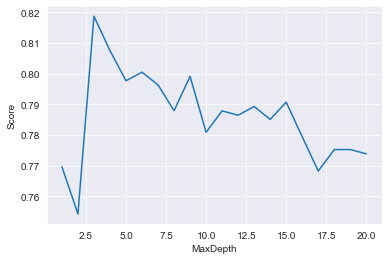

In [766]:
# check for the best parameters
maxDepth = np.arange(1,21)
parameters = {'model__max_depth': maxDepth
             }

# define pipeline for the grid search
DTpipe = Pipeline(steps=[('model',DecisionTreeClassifier())])
DTclf = GridSearchCV(DTpipe, parameters, scoring ='accuracy')

# find the estimator with best parameters and training data
DTclf.fit(X_train, y_train)
  
print("Best parameters set found on validation set:")
print()
print(DTclf.best_params_,f'score: {DTclf.best_score_}')
print()

# see the score
DTclf_score = DTclf.score(X_test,y_test)
print(f'Decision Tree model score (validation data): {DTclf_score:.4f}')

# plot results
plt.plot(maxDepth,DTclf.cv_results_['mean_test_score'])
plt.xlabel('MaxDepth')
plt.ylabel('Score')
plt.show()


#### Random Forest Classifier


In [767]:
# Number of trees in random forest
n_estimators = [100,200,300,500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None, 3,4,5]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RFclf = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, n_jobs = -1)

# fit random forest
RFclf.fit(X_train,y_train)

print("Best parameters set found on validation set:")
print()
print(RFclf.best_params_,f'score: {RFclf.best_score_}')
print()

# print feature importance
print(list(zip(features.columns,RFclf.best_estimator_.feature_importances_)))
print()

# get the score
RFclf_score = RFclf.score(X_test,y_test)
print(f'Random forest model score (validation data): {RFclf_score:.4f}')


Best parameters set found on validation set:

{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False} score: 0.8369939919235694

[('Sex', 0.20243746292109427), ('Age', 0.12314071411994777), ('FirstClass', 0.043154943539721935), ('SecondClass', 0.025520737983619757), ('ThirdClass', 0.08235165362047747), ('Family', 0.0767935464401764), ('Embarked_C', 0.01049991560213377), ('Embarked_Q', 0.005045765715288728), ('Embarked_S', 0.011251913805712343), ('Fare', 0.058878476032463344), ('Master', 0.018379631845858915), ('Miss', 0.05241286515690565), ('Mr', 0.20364195108237348), ('Mrs', 0.07469936182828013), ('Other', 0.01179106030594608)]

Random forest model score (validation data): 0.8827


#### Gradient Boosting Classifier


In [768]:
# define parameters for the grid search
param_grid = {'learning_rate': [0.1, 0.02, 0.022],
              'subsample'    : [1.0, 0.5, 0.6, 0.7],
              'n_estimators' : [100,150,200],
              'max_depth'    : [3,4]
              }

GBclf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring ='accuracy', n_jobs = -1)

# find the estimator with best parameters and training data
GBclf.fit(X_train, y_train)
  
print("Best parameters set found on validation set:")
print()
print(GBclf.best_params_,f'score: {GBclf.best_score_}')
print()

# Score the model on the test data
GBclf_score = GBclf.score(X_test,y_test)
print(f'Gradient Boosting Classifier score (validation data): {GBclf_score:.4f}')

Best parameters set found on validation set:

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} score: 0.8356446370530877

Gradient Boosting Classifier score (validation data): 0.8547


#### XGBoost

In [769]:
param_grid = {'learning_rate': [0.1, 0.02, 0.022],
              'subsample'    : [1.0, 0.5, 0.6, 0.7],
              'n_estimators' : [100,150,200,250],
              'max_depth'    : [3,4],
              'min_child_weight': range(1,4,2)
              }

XGBclf = GridSearchCV(XGBClassifier(), param_grid, scoring ='accuracy',n_jobs = -1)

# find the estimator with best parameters and training data
XGBclf.fit(X_train, y_train)
  
print("Best parameters set found on validation set:")
print()
print(XGBclf.best_params_,f'score: {XGBclf.best_score_}')
print()

# Score the model on the test data
XGBclf_score = XGBclf.score(X_test,y_test)
print(f'XGB Classifier score (validation data): {XGBclf_score:.4f}')

Best parameters set found on validation set:

{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0} score: 0.8426868905742145

XGB Classifier score (validation data): 0.8659


### **Submission**

Now, the best model has to be chosen...

In [770]:
# print scores for each model
print('Model accuracy results')
print()
print('LR:  %.2f%%' % (LRclf_score*100))
print('KNN:  %.2f%%' % (KNclf_score*100))
# print('MNB:  %.2f%%' % (MNBclf_score*100))
print('SVC:  %.2f%%' % (SVCclf_score*100))
print('DT: %.2f%%' % (DTclf_score*100))
print('RF: %.2f%%' % (RFclf_score*100))
print('GBC: %.2f%%' % (GBclf_score*100))
print('XGBC: %.2f%%' % (XGBclf_score*100))
print()

# create models list
models_list = [
                [LRclf,'LR',LRclf_score],
                [KNclf,'KNN',KNclf_score],
                # [MNBclf,'MNB',MNBclf_score],
                [SVCclf,'SVC',SVCclf_score],
                [DTclf,'DT',DTclf_score],
                [RFclf,'RF',RFclf_score],
                [GBclf,'GBC',GBclf_score],
                [XGBclf,'XGBC',XGBclf_score]
                ]

# get scores for each model and choose the highest one
model_scores = [model[2] for model in models_list]
best_model_index = np.argmax(model_scores)

# define best model
final_model = models_list[best_model_index][0]
print(f'Best model is {models_list[best_model_index][1]} with the accuracy of {max(model_scores):.4f}')

# # choose model manually
# final_model = LRclf

Model accuracy results

LR:  86.03%
KNN:  83.24%
SVC:  84.36%
DT: 86.03%
RF: 88.27%
GBC: 85.47%
XGBC: 86.59%

Best model is RF with the accuracy of 0.8827


### Test data

If we check the test data, we can see that there are missing values under 'Fare'. After we fill the missing values, the data is ready for putting in the final model.

In [771]:
# check test data
print(df_test.info())

df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Sex          418 non-null    int64
 2   Age          418 non-null    int32
 3   Fare         418 non-null    int64
 4   Family       418 non-null    int64
 5   Alone        418 non-null    int32
 6   FirstClass   418 non-null    uint8
 7   SecondClass  418 non-null    uint8
 8   ThirdClass   418 non-null    uint8
 9   Embarked_C   418 non-null    uint8
 10  Embarked_Q   418 non-null    uint8
 11  Embarked_S   418 non-null    uint8
 12  Master       418 non-null    uint8
 13  Miss         418 non-null    uint8
 14  Mr           418 non-null    uint8
 15  Mrs          418 non-null    uint8
 16  Other        418 non-null    uint8
dtypes: int32(2), int64(4), uint8(11)
memory usage: 20.9 KB
None


,PassengerId,Sex,Age,Fare,Family,Alone,FirstClass,SecondClass,ThirdClass,Embarked_C,Embarked_Q,Embarked_S,Master,Miss,Mr,Mrs,Other
0,892,0,34,0,0,1,0,0,1,0,1,0,0,0,1,0,0
1,893,1,47,0,1,0,0,0,1,0,0,1,0,0,0,1,0
2,894,0,62,1,0,1,0,1,0,0,1,0,0,0,1,0,0
3,895,0,27,1,0,1,0,0,1,0,0,1,0,0,1,0,0
4,896,1,22,1,2,0,0,0,1,0,0,1,0,0,0,1,0


Now, we can get the predictions and compose the submission file.

In [772]:
# Select the desired features
test_features = df_test[chosen_features]

# get the predictions
survived = final_model.predict(test_features)
submission = pd.concat([df_test['PassengerId'],pd.Series(survived,name = 'Survived')],axis = 1)

# save submission
submission.to_csv('./submission.csv' ,index = False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
